<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/GANs%20(Generative%20Adversarial%20Networks)/PyTorch_GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='.',
                                           train=True,
                                           transform=transform,
                                           download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [6]:
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [7]:
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [9]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
def scale_image(img):
    out = (img + 1) / 2
    return out

In [11]:
if not os.path.exists('gan_images'):
    os.mkdir('gan_images')

In [12]:
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

d_losses = []
g_losses = []

for epoch in range(200):
    for inputs, _ in data_loader:
        n = inputs.size(0)
        inputs = inputs.reshape(n, 784).to(device)

        ones = ones_[:n]
        zeros = zeros_[:n]

        real_outputs = D(inputs)
        d_loss_real = criterion(real_outputs, ones)

        noise = torch.randn(n, latent_dim).to(device)
        fake_images = G(noise)
        fake_outputs = D(fake_images)
        d_loss_fake = criterion(fake_outputs, zeros)

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        for _ in range(2):
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            fake_outputs = D(fake_images)
            g_loss = criterion(fake_outputs, ones)

            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())


    print(f'Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

    fake_images = fake_images.reshape(-1, 1, 28, 28)
    save_image(scale_image(fake_images), f'gan_images/{epoch+1}.png')

Epoch 0, d_loss: 0.680524468421936, g_loss: 0.6247208118438721
Epoch 1, d_loss: 0.6696575880050659, g_loss: 0.6969504356384277
Epoch 2, d_loss: 0.6676558256149292, g_loss: 0.8211595416069031
Epoch 3, d_loss: 0.6804811358451843, g_loss: 0.9156699180603027
Epoch 4, d_loss: 0.6845699548721313, g_loss: 0.7277848124504089
Epoch 5, d_loss: 0.6902198195457458, g_loss: 0.7415655851364136
Epoch 6, d_loss: 0.689172625541687, g_loss: 0.7649337649345398
Epoch 7, d_loss: 0.685584545135498, g_loss: 0.735643744468689
Epoch 8, d_loss: 0.682279109954834, g_loss: 0.7210904359817505
Epoch 9, d_loss: 0.6838287115097046, g_loss: 0.795956552028656
Epoch 10, d_loss: 0.6877655982971191, g_loss: 0.7460891604423523
Epoch 11, d_loss: 0.6897257566452026, g_loss: 0.707872748374939
Epoch 12, d_loss: 0.6890357732772827, g_loss: 0.7210544943809509
Epoch 13, d_loss: 0.6727859377861023, g_loss: 0.6761667728424072
Epoch 14, d_loss: 0.6694492101669312, g_loss: 0.7424381971359253
Epoch 15, d_loss: 0.6827363967895508, g_lo

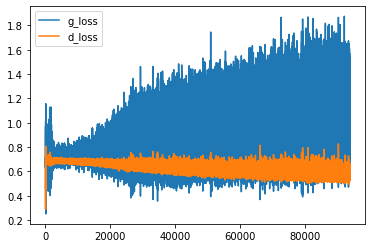

In [13]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend()

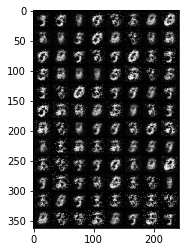

In [14]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

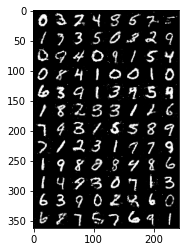

In [15]:
a = imread('gan_images/50.png')
plt.imshow(a)

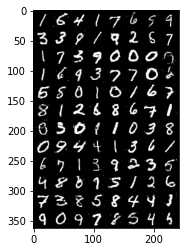

In [16]:
a = imread('gan_images/100.png')
plt.imshow(a)

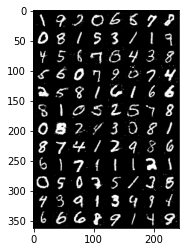

In [17]:
a = imread('gan_images/150.png')
plt.imshow(a)

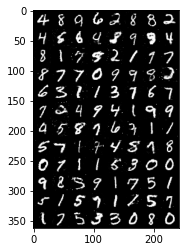

In [18]:
a = imread('gan_images/200.png')
plt.imshow(a)